# 02 - Evolving CartPole Controllers
### [Last Update: March 2022][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/02_mlp_control.ipynb)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

!pip install -q git+https://github.com/RobertTLange/evosax.git@main
!pip install -q gymnax

## Open-ES with MLP Controller

In [1]:
import jax
import jax.numpy as jnp

from evosax import OpenES, ParameterReshaper, FitnessShaper, NetworkMapper
from evosax.utils import ESLog
from evosax.problems import GymnaxFitness

rng = jax.random.PRNGKey(0)
network = NetworkMapper["MLP"](
    num_hidden_units=64,
    num_hidden_layers=2,
    num_output_units=2,
    hidden_activation="relu",
    output_activation="categorical",
)
pholder = jnp.zeros((4,))
params = network.init(
    rng,
    x=pholder,
    rng=rng,
)

param_reshaper = ParameterReshaper(params)

ParameterReshaper: 4610 parameters detected for optimization.


In [2]:
evaluator = GymnaxFitness("CartPole-v1", num_env_steps=200, num_rollouts=16)
evaluator.set_apply_fn(network.apply)

In [3]:
strategy = OpenES(popsize=100,
                  num_dims=param_reshaper.total_params,
                  opt_name="sgd")
strategy.default_params

EvoParams(opt_params=OptParams(lrate_init=0.05, lrate_decay=1.0, lrate_limit=0.001, momentum=0.0, beta_1=None, beta_2=None, beta_3=None, eps=None, max_speed=None), sigma_init=0.03, sigma_decay=1.0, sigma_limit=0.01, init_min=0.0, init_max=0.0, clip_min=-3.4028235e+38, clip_max=3.4028235e+38)

In [4]:
num_generations = 100
print_every_k_gens = 20

es_logging = ESLog(param_reshaper.total_params,
                   num_generations,
                   top_k=5,
                   maximize=True)
log = es_logging.initialize()

fit_shaper = FitnessShaper(centered_rank=True,
                           z_score=False,
                           w_decay=0.1,
                           maximize=True)

state = strategy.initialize(rng)

for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    x, state = strategy.ask(rng_ask, state)
    reshaped_params = param_reshaper.reshape(x)
    fitness = evaluator.rollout(rng_eval, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Generation: ", gen, "Generation: ", log["log_top_1"][gen])

/Users/rob/anaconda3/envs/mle-toolbox/lib/python3.9/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/rob/anaconda3/envs/mle-toolbox/lib/python3.9/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


Generation:  0 Generation:  22.875
Generation:  20 Generation:  81.75
Generation:  40 Generation:  200.0
Generation:  60 Generation:  200.0
Generation:  80 Generation:  200.0


(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'CartPole MLP OpenAI-ES'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

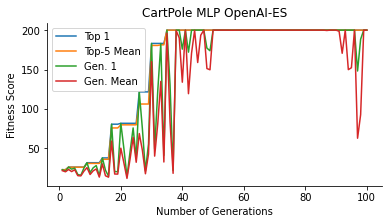

In [5]:
es_logging.plot(log, "CartPole MLP OpenAI-ES")

# PGPE with LSTM Controller

In [6]:
rng = jax.random.PRNGKey(0)
network = NetworkMapper["LSTM"](
    num_hidden_units=32,
    num_output_units=2,
    output_activation="categorical",
)
pholder = jnp.zeros((4,))
carry_init = network.initialize_carry()
params = network.init(
    rng,
    x=pholder,
    carry=carry_init,
    rng=rng,
)

param_reshaper = ParameterReshaper(params)

ParameterReshaper: 4802 parameters detected for optimization.


In [7]:
evaluator = GymnaxFitness("CartPole-v1", num_env_steps=200, num_rollouts=16)
evaluator.set_apply_fn(network.apply, network.initialize_carry)

In [12]:
from evosax import PGPE

popsize = 100
strategy = PGPE(popsize, param_reshaper.total_params,
                elite_ratio=0.1, opt_name="adam")

# Update basic parameters of PGPE strategy
es_params = strategy.default_params
es_params      

EvoParams(opt_params=OptParams(lrate_init=0.05, lrate_decay=1.0, lrate_limit=0.001, momentum=None, beta_1=0.99, beta_2=0.999, beta_3=None, eps=1e-08, max_speed=None), sigma_init=0.03, sigma_decay=1.0, sigma_limit=0.01, sigma_lrate=0.2, sigma_max_change=0.2, init_min=0.0, init_max=0.0, clip_min=-3.4028235e+38, clip_max=3.4028235e+38)

In [13]:
num_generations = 100
print_every_k_gens = 20

es_logging = ESLog(param_reshaper.total_params,
                   num_generations,
                   top_k=5,
                   maximize=True)
log = es_logging.initialize()

fit_shaper = FitnessShaper(w_decay=0.1,
                           maximize=True)

state = strategy.initialize(rng, es_params)

for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    x, state = strategy.ask(rng_ask, state, es_params)
    reshaped_params = param_reshaper.reshape(x)
    fitness = evaluator.rollout(rng_eval, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state, es_params)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Generation: ", gen, "Performance: ", log["log_top_1"][gen])

Generation:  0 Performance:  21.875
Generation:  20 Performance:  44.625
Generation:  40 Performance:  194.4375
Generation:  60 Performance:  199.3125
Generation:  80 Performance:  200.0


(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'CartPole LSTM PGPE'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

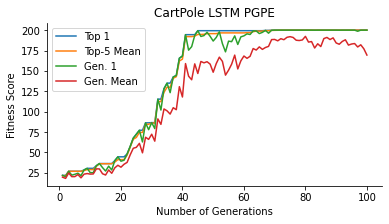

In [14]:
es_logging.plot(log, "CartPole LSTM PGPE")